In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import spacy
import re
import json
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from transformers import pipeline
%matplotlib inline

In [54]:
def normalizeDoc(nlp, doc, nMinCharacters = 4):
    """
    Normaliza un texto eliminando palabras por debajo del mínimo de caracteres, stop words y números.
    Para ello, tokeniza empleando un modelo de Spacy.
    """
    # Separar en tokens
    tokens = nlp(doc)
    # Filtrar tokens
    filtered_tokens = [t.lower_ for t in tokens if (len(t.text) >= nMinCharacters) and not t.is_punct and not re.match('[0-9]+', t.text)]
    # Recombinamos los tokens
    doc = ' '.join(filtered_tokens)
    
    return doc

def obtainSimilarity(doc, docIndex: list[str], vectorizerDict: dict[str]):
    """
    Obtiene la matriz de similitud calculada como la distancia coseno empleando los vectorizadores proporcionados.
    """
    similarityDict = {}
    for tag, vectorizer in vectorizerDict.items():
        vectorizedMatrix = vectorizer.fit_transform(doc)
        vectorizedDf = pd.DataFrame(vectorizedMatrix.toarray(), columns = vectorizer.get_feature_names_out(), index = docIndex)
        similarity = cosine_similarity(vectorizedDf)
        similarityDf = pd.DataFrame(similarity, index = vectorizedDf.index, columns = vectorizedDf.index)
        similarityDict[tag] = similarityDf

    return similarityDict


def findMostSimilar(similarityDict: dict[str, pd.DataFrame], docIndex: list[str], nMostSimilars: int = 1, classes: None | list[str] = None):
    """
    Encuentra el valor más similar para todas las matrices de similitud proporcionadas.
    """
    # Crear df de resultados
    if classes is not None:
        docIndex = list(filter(lambda x: not (x in classes), docIndex))
    mostSimilarDf = pd.DataFrame(index = docIndex, columns = list(similarityDict.keys()))

    for tag, similarity in similarityDict.items():
        
        mostSimilarOptions = []

        for index, row in similarity.iterrows():
            if classes is None:
                # Eliminar la similitud consigo mismo
                rowFiltered = row.drop(index)
            else:
                # Saltar las filas de clases
                if index in classes:
                    continue
                # Seleccionar la similitud con las clases
                rowFiltered = row[classes]
            
            # Buscar la máxima similitud
            mostSimilarIdxs  = rowFiltered.nlargest(nMostSimilars).index.tolist()
            opt  = ', '.join([f"{i} ({rowFiltered[i]:.2f})" for i in mostSimilarIdxs])
            mostSimilarOptions.append(opt)

        # Escribir los resultados
        mostSimilarDf[tag] = mostSimilarOptions
    
    return mostSimilarDf

In [55]:
# python -m spacy download es_core_news_lg
nlp = spacy.load("es_core_news_lg")

# Cargar los datos
df = pd.read_csv('data/Distritos_v3.csv')

with open('data/tipologyDescription.json', 'r', encoding = 'utf-8') as f:
    tipology: dict = json.load(f)

with open('data/tipologyDescription.json', 'r', encoding = 'utf-8') as f:
    tipology: dict = json.load(f)

In [56]:
# Aplicar preprocesamiento
corpus = df['Información'].tolist()
descriptions = [normalizeDoc(nlp, doc) for doc in corpus]
descriptionIndex = list(df['Zona'].values)

In [57]:
# Obtener similitud entre barrios
models = {'BoW': CountVectorizer(), 'TF-IDF': TfidfVectorizer(), 'TF-IDF N-gram(1,3)': TfidfVectorizer(ngram_range = (1, 3))}
similarityDict = obtainSimilarity(descriptions, descriptionIndex, models)
mostSimilarBarrioDf = findMostSimilar(similarityDict, descriptionIndex)
mostSimilarBarrioDf

,BoW,TF-IDF,"TF-IDF N-gram(1,3)"
Ciutat Vella,L´Eixample (0.57),L´Eixample (0.35),L´Eixample (0.14)
L´Eixample,Ciutat Vella (0.57),Ciutat Vella (0.35),Ciutat Vella (0.14)
Extramurs,L´Eixample (0.54),L´Eixample (0.33),L´Eixample (0.11)
Campanar,Rascanya (0.36),Rascanya (0.30),Rascanya (0.10)
La Zaidia,El Pla del Real (0.38),L’Olivereta (0.30),Camins al Grau (0.10)
El Pla del Real,Rascanya (0.48),Rascanya (0.34),Rascanya (0.13)
L’Olivereta,Benicalap (0.37),La Zaidia (0.30),Benicalap (0.08)
Patraix,Quatre Carreres (0.46),L´Eixample (0.24),L´Eixample (0.08)
Jesús,La Patacona (Alboraya) (0.36),La Patacona (Alboraya) (0.16),Benicalap (0.05)
Quatre Carreres,L´Eixample (0.54),L´Eixample (0.31),Rascanya (0.11)


In [58]:
# Obtener similitud con clases
classes = list(tipology.keys())
classDescriptions = [normalizeDoc(nlp, doc) for doc in list(tipology.values())]
descriptionsAndClasses = descriptions + classDescriptions
descriptionAndClassesIndex = descriptionIndex + classes

similarityDict = obtainSimilarity(descriptionsAndClasses, descriptionAndClassesIndex, models)
mostSimilarDf = findMostSimilar(similarityDict, descriptionAndClassesIndex, 2, classes)
mostSimilarDf

,BoW,TF-IDF,"TF-IDF N-gram(1,3)"
Ciutat Vella,"suburbano (0.27), histórico (0.22)","suburbano (0.14), histórico (0.12)","suburbano (0.04), histórico (0.03)"
L´Eixample,"suburbano (0.32), comercial (0.27)","suburbano (0.18), turístico (0.14)","suburbano (0.06), universitario (0.05)"
Extramurs,"turístico (0.20), comercial (0.19)","suburbano (0.13), comercial (0.09)","suburbano (0.04), multicultural (0.03)"
Campanar,"familiar (0.11), comercial (0.10)","comercial (0.04), familiar (0.04)","comercial (0.01), suburbano (0.01)"
La Zaidia,"turístico (0.12), comercial (0.12)","comercial (0.05), suburbano (0.05)","comercial (0.01), turístico (0.01)"
El Pla del Real,"suburbano (0.19), familiar (0.10)","suburbano (0.08), familiar (0.07)","suburbano (0.02), familiar (0.02)"
L’Olivereta,"comercial (0.10), suburbano (0.09)","comercial (0.05), lujo (0.04)","comercial (0.01), lujo (0.01)"
Patraix,"suburbano (0.31), familiar (0.23)","suburbano (0.17), familiar (0.14)","suburbano (0.05), familiar (0.04)"
Jesús,"turístico (0.12), comercial (0.12)","turístico (0.06), comercial (0.03)","turístico (0.02), comercial (0.01)"
Quatre Carreres,"suburbano (0.32), familiar (0.19)","suburbano (0.15), familiar (0.09)","suburbano (0.04), familiar (0.03)"


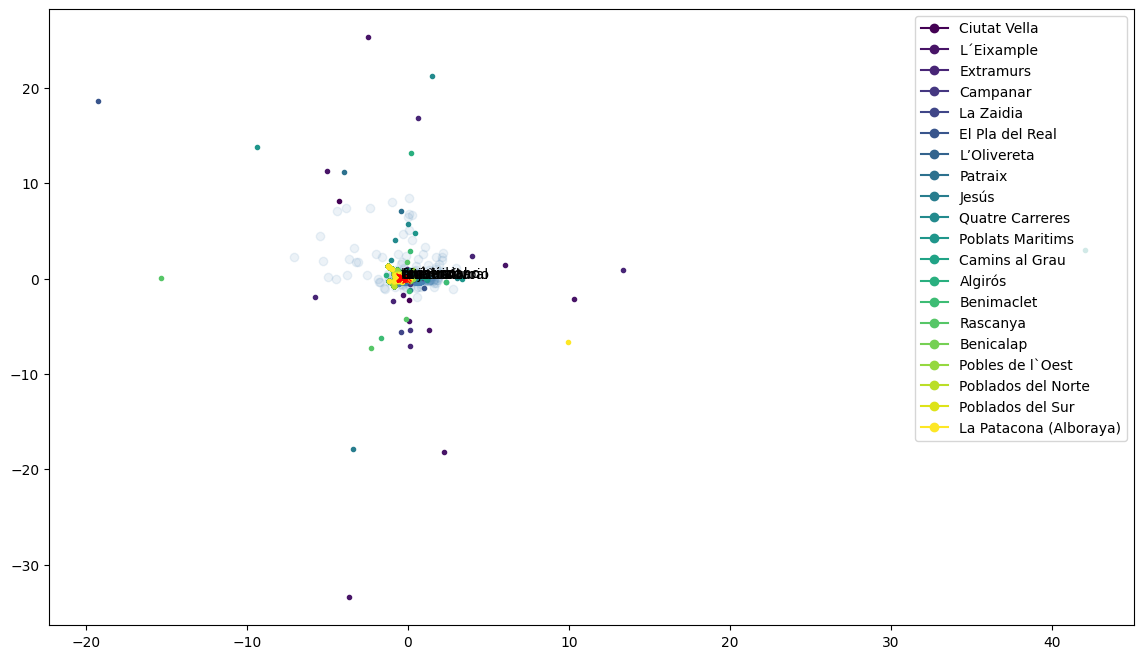

In [59]:
# Obtener representación vectorial de lexemas y las palabras de los textos
words = []
for s in descriptions:
    word_list = s.split()
    words.extend(word_list)
lexemas = [nlp.vocab[orth] for orth in nlp.vocab.vectors]
lexemasRand = [t.text for t in np.random.choice(lexemas, 10000, replace = False)]
wordsForTsne = lexemasRand + words + classes
wordVectors = np.array([nlp(word).vector for word in wordsForTsne])

# Obtener embedding a partir de los vectores
tsne = TSNE(n_components = 2, random_state = 0, n_iter = 250, perplexity = 50, init = 'random', learning_rate = 'auto')
np.set_printoptions(suppress = True)
T = tsne.fit_transform(wordVectors)

# Representar lexemas
fig, ax = plt.subplots(figsize = (14, 8))
ax.scatter(T[:len(lexemasRand), 0], T[:len(lexemasRand), 1], c = 'steelblue', alpha = 0.1)

# Representar palabras con color por barrio
cmap = plt.get_cmap('viridis', len(descriptionIndex))

auxIdx = len(lexemasRand)
for i, description in enumerate(descriptions):
    # Filtrar por barrio
    nWords = len([word for word in description.split() if word])
    TFiltered = T[auxIdx:(auxIdx+nWords), :]
    auxIdx += nWords

    ax.plot(TFiltered[:, 0], TFiltered[:, 1], '.', c = cmap(i / len(descriptionIndex)))

# Añadir la leyenda de colores
colorTags = [(tag, cmap(i / len(descriptionIndex))) for i, tag in enumerate(descriptionIndex)]
colorLegend = [plt.Line2D([0], [0], marker = 'o', c = mcolors.to_rgb(color), label = tag) for tag, color in colorTags]
ax.legend(handles = colorLegend, loc = 'best')

# Representar clases
auxIdx = len(lexemasRand) + len(words)
ax.plot(T[auxIdx:, 0], T[auxIdx:, 1], 'x', c = 'red')

for label, x, y in zip(classes, T[auxIdx:, 0], T[auxIdx:, 1]):
    ax.annotate(label, xy = (x, y), xytext = (0, 0), textcoords = 'offset points')

plt.show()

In [60]:
tipology.keys()

dict_keys(['histórico', 'lujo', 'multicultural', 'familiar', 'universitario', 'turístico', 'alternativo', 'suburbano', 'comercial'])

In [61]:
# Clasificar con modelo de hugging-face
classifier = pipeline("zero-shot-classification")
results = []
for doc in descriptions:
    results.append(classifier(
        doc,
        candidate_labels = ['histórico', 'lujo', 'multicultural', 'familiar', 'universitario', 'turístico', 'suburbano', 'comercial']))

# Añadir resultados al df
for barrio, result in zip(descriptionIndex, results):
    mostSimilarDf.loc[barrio, 'zero-shot-classification'] = f"{result['labels'][0]} ({result['scores'][0]:.2f}), {result['labels'][1]} ({result['scores'][1]:.2f})"

mostSimilarDf

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.
c:\repos\mcd-nlp-proyecto\.venv\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


,BoW,TF-IDF,"TF-IDF N-gram(1,3)",zero-shot-classification
Ciutat Vella,"suburbano (0.27), histórico (0.22)","suburbano (0.14), histórico (0.12)","suburbano (0.04), histórico (0.03)","histórico (0.35), turístico (0.19)"
L´Eixample,"suburbano (0.32), comercial (0.27)","suburbano (0.18), turístico (0.14)","suburbano (0.06), universitario (0.05)","comercial (0.48), turístico (0.19)"
Extramurs,"turístico (0.20), comercial (0.19)","suburbano (0.13), comercial (0.09)","suburbano (0.04), multicultural (0.03)","multicultural (0.41), turístico (0.25)"
Campanar,"familiar (0.11), comercial (0.10)","comercial (0.04), familiar (0.04)","comercial (0.01), suburbano (0.01)","comercial (0.36), turístico (0.28)"
La Zaidia,"turístico (0.12), comercial (0.12)","comercial (0.05), suburbano (0.05)","comercial (0.01), turístico (0.01)","familiar (0.36), multicultural (0.32)"
El Pla del Real,"suburbano (0.19), familiar (0.10)","suburbano (0.08), familiar (0.07)","suburbano (0.02), familiar (0.02)","histórico (0.48), universitario (0.12)"
L’Olivereta,"comercial (0.10), suburbano (0.09)","comercial (0.05), lujo (0.04)","comercial (0.01), lujo (0.01)","turístico (0.70), lujo (0.09)"
Patraix,"suburbano (0.31), familiar (0.23)","suburbano (0.17), familiar (0.14)","suburbano (0.05), familiar (0.04)","multicultural (0.67), turístico (0.07)"
Jesús,"turístico (0.12), comercial (0.12)","turístico (0.06), comercial (0.03)","turístico (0.02), comercial (0.01)","multicultural (0.63), suburbano (0.08)"
Quatre Carreres,"suburbano (0.32), familiar (0.19)","suburbano (0.15), familiar (0.09)","suburbano (0.04), familiar (0.03)","comercial (0.78), familiar (0.07)"


### Word Embedding

In [62]:
# !pip install scipy==1.10.1
from gensim.models import Word2Vec
corpus = [description.split() for description in descriptions]
model = Word2Vec(
    corpus,
    vector_size = 50,
    window = 5,
    min_count = 5,
    epochs = 50)

len(model.wv.vectors)

102

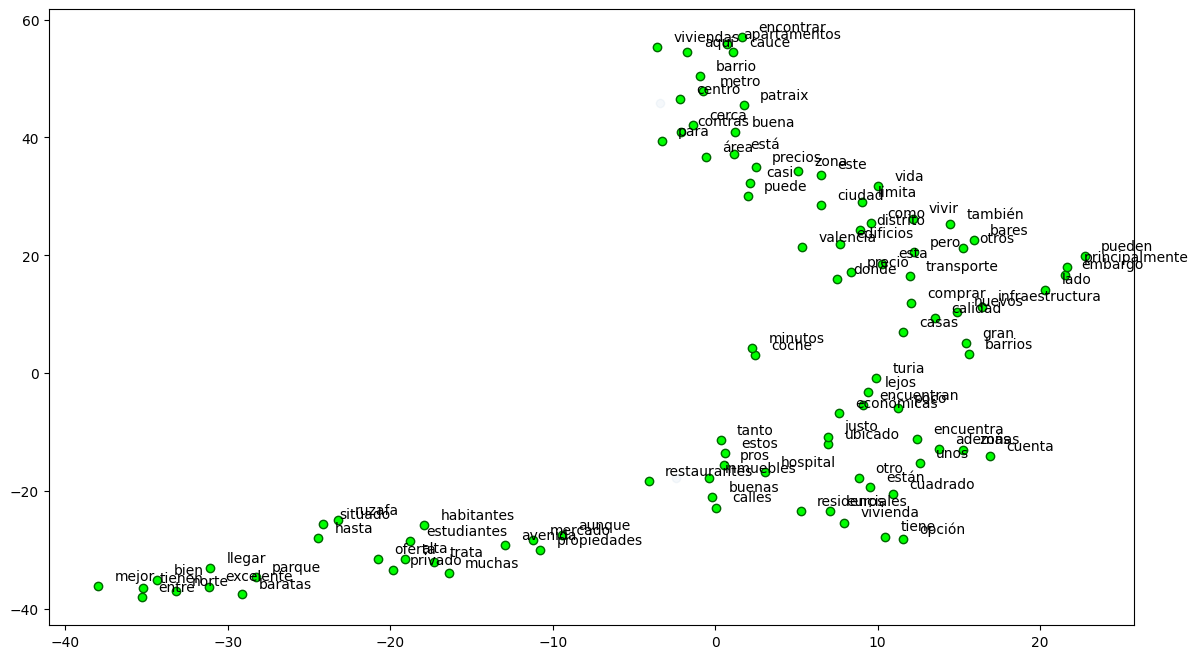

In [63]:
np.random.seed=42
palabras = model.wv.index_to_key
palabras_sm = np.random.choice(palabras, 100, replace=False)
vectores = model.wv[palabras]
index_sm = [model.wv.key_to_index[p] for p in palabras_sm]


tsne = TSNE(n_components = 2,
            random_state = 0,
            n_iter = 1000,
            perplexity = 5,
            init = 'random',
            learning_rate = 'auto')
np.set_printoptions(suppress=True)
    
T = tsne.fit_transform(vectores)

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', alpha=0.05)

labels = palabras_sm
T_sm = T[index_sm,:]
plt.scatter(T_sm[:, 0], T_sm[:, 1], c='lime', edgecolors='darkgreen')
for label, x, y in zip(labels, T_sm[:, 0],T_sm[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')


### Document Embedding

In [71]:
docEmbedding = df[['Zona', 'Información']].copy()
docEmbedding.set_index('Zona', inplace = True)
docEmbedding['doc'] = docEmbedding['Información'].apply(nlp)

descriptionEmbedding = {clase: nlp(doc) for clase, doc in tipology.items() if clase}

for idx, row in docEmbedding.iterrows():
    results = pd.DataFrame(index = list(descriptionEmbedding.keys()))
    for clase, claseDoc in descriptionEmbedding.items():
        results.loc[clase, 'similarity'] = row['doc'].similarity(claseDoc)
    results.sort_values('similarity', inplace = True)
    docEmbedding.loc[idx, 'mostSimilar'] = ', '.join([f"{results.index[i]} ({results['similarity'].iloc[i]:.2f})" for i in range(2)])

mostSimilarDf['docEmbedding'] = docEmbedding['mostSimilar']
mostSimilarDf

,BoW,TF-IDF,"TF-IDF N-gram(1,3)",zero-shot-classification,docEmbedding
Ciutat Vella,"suburbano (0.27), histórico (0.22)","suburbano (0.14), histórico (0.12)","suburbano (0.04), histórico (0.03)","histórico (0.35), turístico (0.19)","familiar (0.92), multicultural (0.93)"
L´Eixample,"suburbano (0.32), comercial (0.27)","suburbano (0.18), turístico (0.14)","suburbano (0.06), universitario (0.05)","comercial (0.48), turístico (0.19)","familiar (0.93), multicultural (0.94)"
Extramurs,"turístico (0.20), comercial (0.19)","suburbano (0.13), comercial (0.09)","suburbano (0.04), multicultural (0.03)","multicultural (0.41), turístico (0.25)","familiar (0.90), multicultural (0.90)"
Campanar,"familiar (0.11), comercial (0.10)","comercial (0.04), familiar (0.04)","comercial (0.01), suburbano (0.01)","comercial (0.36), turístico (0.28)","alternativo (0.71), multicultural (0.72)"
La Zaidia,"turístico (0.12), comercial (0.12)","comercial (0.05), suburbano (0.05)","comercial (0.01), turístico (0.01)","familiar (0.36), multicultural (0.32)","alternativo (0.86), familiar (0.87)"
El Pla del Real,"suburbano (0.19), familiar (0.10)","suburbano (0.08), familiar (0.07)","suburbano (0.02), familiar (0.02)","histórico (0.48), universitario (0.12)","familiar (0.88), multicultural (0.88)"
L’Olivereta,"comercial (0.10), suburbano (0.09)","comercial (0.05), lujo (0.04)","comercial (0.01), lujo (0.01)","turístico (0.70), lujo (0.09)","multicultural (0.83), familiar (0.83)"
Patraix,"suburbano (0.31), familiar (0.23)","suburbano (0.17), familiar (0.14)","suburbano (0.05), familiar (0.04)","multicultural (0.67), turístico (0.07)","familiar (0.91), multicultural (0.91)"
Jesús,"turístico (0.12), comercial (0.12)","turístico (0.06), comercial (0.03)","turístico (0.02), comercial (0.01)","multicultural (0.63), suburbano (0.08)","familiar (0.82), multicultural (0.83)"
Quatre Carreres,"suburbano (0.32), familiar (0.19)","suburbano (0.15), familiar (0.09)","suburbano (0.04), familiar (0.03)","comercial (0.78), familiar (0.07)","familiar (0.89), multicultural (0.90)"
